In [1]:
import pandas as pd
#from datasets.BrainAgeContinuous import BrainAgeContinuous
#from datasets.BrainAgeDataset import BrainAgeDataset
#from datasets.CatsinomDataset import CatsinomDataset
#from datasets.LIDCDataset import LIDCDataset
from models.unet3d import EncoderModelGenesis
import torchvision.models as tvmodels
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from statsmodels.distributions.empirical_distribution import ECDF
#import statsmodels.api as sm

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from scipy.stats import gaussian_kde, norm, multivariate_normal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import torch.nn as nn

#from statsmodels.nonparametric.kernel_density import KDEMultivariate

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import seuclidean, euclidean, mahalanobis, pdist, squareform
from sklearn.random_projection import SparseRandomProjection
import active_dynamicmemory.utils as cutils
import pickle
from datasets.BatchDataset import CardiacBatch
from active_dynamicmemory.ActiveDynamicMemory import MemoryItem
from datasets.ContinuousDataset import CardiacContinuous

In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/m

In [2]:
def gram_matrix(input):
    # taken from: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    grams = []

    for i in range(a):
        features = input[i].view(b, c * d)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        grams.append(G.div(b * c * d))

    return grams


def gram_matrix_3d(input, pool_factor=1):
    # taken from: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    a, b, c, d, e = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    grams = []

    for i in range(a):
        features = input[i].view(b, c * d * e)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        if pool_factor==1:
            grams.append(G.div(b * c * d * e))
        else:
            pool = nn.MaxPool2d(pool_factor)
            gram = G.div(b * c * d * e)
            gram_pooled = pool(gram[None, :])
            grams.append(gram_pooled[0])

    return grams

def gram_hook(m, input, output):
    grammatrices.append(gram_matrix_3d(input[0]))

def register_hooks():
    for layer in gramlayers:
        layer.register_forward_hook(gram_hook)
        
def gram_hook_2d(m, input, output):
    grammatrices.append(gram_matrix(input[0]))

def register_hooks_2d(layers):
    for layer in layers:
        layer.register_forward_hook(gram_hook_2d)

In [3]:
device = torch.device('cuda')

stylemodel = tvmodels.resnet50(pretrained=True)
stylemodel.to(device)
stylemodel.eval()
gramlayers = [stylemodel.layer2[-1].conv1]
register_hooks_2d(gramlayers)

In [4]:
grammatrices=[]
device = torch.device('cuda')
num_items = 128

dl = torch.utils.data.DataLoader(CardiacBatch('/project/catinous/cardiacslicessplitsingle.csv',
                                            iterations=None,
                                            batch_size=8,
                                            split=['base']),
                            batch_size=8, num_workers=4, pin_memory=True, collate_fn=None)

memoryitems = []
for batch in dl:
    torch.cuda.empty_cache()

    x, y, scanner, filepath = batch

    if type(x) is list:
        x = torch.stack(x)

    x = x.to(device)

    if x.size()[1]==1:
        xstyle = torch.cat([x, x, x], dim=1)
    else:
        xstyle = x
    _ = stylemodel(xstyle)

    for i, f in enumerate(filepath):
        target = y[i]
        if type(target) == torch.Tensor:
            det_target = target.detach().cpu()
        else:
            det_target = {}
            for k, v in target.items():
                det_target[k] = v.detach().cpu()

        grammatrix = [bg[i].detach().cpu().numpy().flatten() for bg in grammatrices]
        memoryitems.append(MemoryItem(x[i].detach().cpu(), det_target, f, scanner[i],
                                      current_grammatrix=grammatrix[0],
                                      pseudo_domain=0))

    if len(memoryitems) >= num_items:
        break

    grammatrices = []

init cardiac batch with datasetfile /project/catinous/cardiacslicessplitsingle.csv


In [5]:
len(memoryitems)

128

In [6]:
len(grammatrices[0])

8

In [7]:
graminits = []
for mi in memoryitems:
    graminits.append(mi.current_grammatrix)


clf = IsolationForest(n_estimators=10, random_state=1, warm_start=True, contamination=0.10).fit(graminits)

In [8]:
dl = torch.utils.data.DataLoader(CardiacContinuous('/project/catinous/cardiacslicessplitsingle.csv',
                                                         transition_phase_after=0.8,
                                                         seed=1,
                                                         order=['Siemens', 'GE', 'Philips', 'Canon']),
                              batch_size=8, num_workers=8, drop_last=True,
                              collate_fn=None)

['Siemens', 'GE', 'Philips', 'Canon']


In [9]:
grammatrices = []
for k, batch in enumerate(dl):
    train_memitems = []
    grammatrices = []
    torch.cuda.empty_cache()

    x, y, scanner, filepath = batch

    if type(x) is list:
        x = torch.stack(x)

    x = x.to(device)

    if x.size()[1]==1:
        xstyle = torch.cat([x, x, x], dim=1)
    else:
        xstyle = x
    _ = stylemodel(xstyle)

    for i, f in enumerate(filepath):
        target = y[i]
        if type(target) == torch.Tensor:
            det_target = target.detach().cpu()
        else:
            det_target = {}
            for k, v in target.items():
                det_target[k] = v.detach().cpu()

        grammatrix = [bg[i].detach().cpu().numpy().flatten() for bg in grammatrices]
        train_memitems.append(MemoryItem(x[i].detach().cpu(), det_target, f, scanner[i],
                                      current_grammatrix=grammatrix[0],
                                      pseudo_domain=0))
    
    for mi in train_memitems:
        print(mi.scanner, clf.predict(mi.current_grammatrix.reshape(1, -1)))
        

Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [1]
Siemens [-1]
Siemens [-1]
Siemens [1]
Siemen

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8898703a7981>", line 29, in <module>
    grammatrix = [bg[i].detach().cpu().numpy().flatten() for bg in grammatrices]
  File "<ipython-input-9-8898703a7981>", line 29, in <listcomp>
    grammatrix = [bg[i].detach().cpu().numpy().flatten() for bg in grammatrices]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mperkonigg/.local/lib/

TypeError: object of type 'NoneType' has no len()

In [4]:
matrices_for_embedding = []
base_matrices = []
grammatrices = []
scanners = []

for batch in dl:
    images, targets, scanner, filepath = batch
    
    x = images.to(device)
    x = torch.cat([x, x, x], dim=1)
    y_style = stylemodel(x.float())
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        grammatrices = []
    if scanner[0] == 'Siemens':
        scanners.append(0)
    elif scanner[0] == 'GE':
        scanners.append(1)
    elif scanner[0]=='Philips':
        scanners.append(2)
    else:
        scanners.append(3)

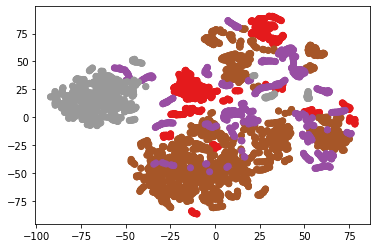

In [5]:
tsne = TSNE(n_components=2, perplexity=30)
elements_tsne = tsne.fit_transform(matrices_for_embedding)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners, cmap='Set1')

(262144,)

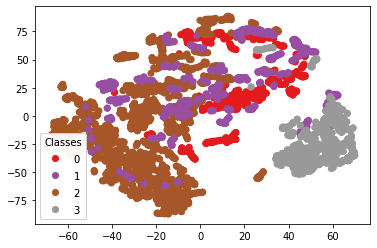

In [19]:
fig, ax = plt.subplots()
scatter = ax.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners, cmap='Set1', )
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [15]:
matrices_for_embedding[0].shape

(65536,)

matrices_for_embeddingGACY

In [3]:
device = torch.device('cuda')

stylemodel = tvmodels.resnet50(pretrained=True)
stylemodel.to(device)
stylemodel.eval()
gramlayers = [stylemodel.layer1[-1].conv1,
                          stylemodel.layer2[-1].conv1]
register_hooks_2d(gramlayers)

dl = torch.utils.data.DataLoader(LIDCDataset('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
                               iterations=None,
                               batch_size=4,
                               split=['base_train']),
               batch_size=1, num_workers=4, pin_memory=True, shuffle=True,
                    collate_fn=cutils.collate_fn)

dl_trainset = torch.utils.data.DataLoader(LIDCDataset('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv',
                               iterations=None,
                               batch_size=4,
                               split=['train']),
               batch_size=1, num_workers=4, pin_memory=True, shuffle=True,
                    collate_fn=cutils.collate_fn)

In [4]:
with open('initimages.pkl', 'rb') as f:
    initimages = pickle.load(f)
    
with open('batchimages.pkl', 'rb') as f:
    batchimages = pickle.load(f)

In [5]:
with open('graminits.pkl', 'rb') as f:
    graminits = pickle.load(f)

In [6]:
graminits[-4]

array([1.2230446e-07, 6.1188661e-07, 2.7963972e-07, ..., 2.0711517e-05,
       6.8791751e-06, 2.5979023e-05], dtype=float32)

In [7]:
grammatrices = []
stylemodel(initimages.to(device))
grammatrices

[[tensor([[1.2230e-07, 6.1189e-07, 2.7964e-07,  ..., 6.8759e-07, 1.9141e-07,
           2.6144e-07],
          [6.1189e-07, 5.5636e-05, 1.5475e-05,  ..., 4.5849e-05, 9.8103e-06,
           1.7065e-05],
          [2.7964e-07, 1.5475e-05, 1.8411e-05,  ..., 2.7238e-05, 6.8293e-06,
           7.1689e-06],
          ...,
          [6.8759e-07, 4.5849e-05, 2.7238e-05,  ..., 8.9272e-05, 2.2973e-05,
           2.0712e-05],
          [1.9141e-07, 9.8103e-06, 6.8293e-06,  ..., 2.2973e-05, 2.2250e-05,
           6.8792e-06],
          [2.6144e-07, 1.7065e-05, 7.1689e-06,  ..., 2.0712e-05, 6.8792e-06,
           2.5979e-05]], device='cuda:0', grad_fn=<DivBackward0>),
  tensor([[1.5585e-07, 6.4088e-07, 2.6210e-07,  ..., 6.4839e-07, 1.5884e-07,
           5.3770e-07],
          [6.4088e-07, 5.2118e-05, 1.5566e-05,  ..., 4.3894e-05, 1.0406e-05,
           1.3349e-05],
          [2.6210e-07, 1.5566e-05, 1.8841e-05,  ..., 2.7395e-05, 8.1205e-06,
           4.1589e-06],
          ...,
          [6.4839e

In [8]:
with open('grammatrices.pkl', 'rb') as f:
    grammatrices = pickle.load(f)
grammatrices[0][0].flatten()

tensor([2.4277e-05, 1.4544e-05, 2.0965e-05,  ..., 4.4857e-05, 4.4442e-05,
        9.2610e-05], device='cuda:0', grad_fn=<ViewBackward>)

In [9]:
batchimages.shape

torch.Size([4, 3, 512, 512])

In [13]:
grammatrices = []
stylemodel(batchimages.to(device))
grammatrices

[[tensor([[2.7324e-07, 9.4219e-07, 3.6022e-07,  ..., 1.1671e-06, 4.1239e-07,
           2.5058e-07],
          [9.4219e-07, 5.4386e-05, 1.5574e-05,  ..., 4.4822e-05, 1.6130e-05,
           1.3747e-05],
          [3.6022e-07, 1.5574e-05, 1.9381e-05,  ..., 2.5519e-05, 1.1957e-05,
           4.5001e-06],
          ...,
          [1.1671e-06, 4.4822e-05, 2.5519e-05,  ..., 8.3958e-05, 3.7214e-05,
           1.4662e-05],
          [4.1239e-07, 1.6130e-05, 1.1957e-05,  ..., 3.7214e-05, 4.2990e-05,
           6.5469e-06],
          [2.5058e-07, 1.3747e-05, 4.5001e-06,  ..., 1.4662e-05, 6.5469e-06,
           1.6573e-05]], device='cuda:0', grad_fn=<DivBackward0>),
  tensor([[1.7677e-07, 6.9455e-07, 2.7676e-07,  ..., 8.4310e-07, 2.5366e-07,
           4.7361e-07],
          [6.9455e-07, 5.4986e-05, 1.5948e-05,  ..., 4.5678e-05, 9.5470e-06,
           1.9281e-05],
          [2.7676e-07, 1.5948e-05, 1.9147e-05,  ..., 2.8325e-05, 6.9662e-06,
           8.5651e-06],
          ...,
          [8.4310e

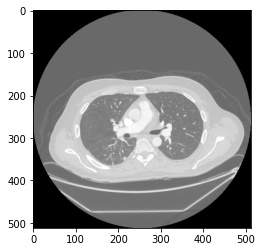

In [24]:
plt.imshow(batchimages[1].cpu()[0])

In [9]:
transformer = SparseRandomProjection(random_state=42, n_components=30)
transformer.fit(graminits)

SparseRandomProjection(n_components=30, random_state=42)

In [12]:
trans_initelements = transformer.transform(graminits)
clf = IsolationForest(n_estimators=10, random_state=42).fit(trans_initelements)
clf.decision_function(trans_initelements)

array([-1.64814529e-05,  3.72142608e-02,  3.93862968e-02,  3.57540876e-02,
       -2.83270197e-02, -5.96758534e-02, -2.37012656e-02,  1.34680638e-02,
        3.78579045e-03, -1.76635279e-03, -2.47125236e-02, -5.66534023e-02,
        1.78593723e-02, -9.71293179e-03,  3.06410703e-02,  1.80707206e-02,
        3.25414333e-02,  4.30791345e-02,  5.13541708e-02, -5.77875370e-02,
       -1.40213135e-01,  3.58611558e-02,  5.11812861e-02,  2.86695559e-02,
        2.89939246e-02,  6.03714753e-02,  4.72039359e-02,  2.61024640e-02,
        3.26153803e-02, -2.89328323e-03,  3.79841484e-02,  3.71078149e-02])

In [19]:
gramm_batch = []
for gm in grammatrices[0]:
    gramm_batch.append(gm.flatten())

In [30]:
for i in range(4):
    tb = transformer.transform(gramm_batch[i].cpu().reshape(1, -1))
    print(clf.decision_function(tb))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

array([-0.13891481])

In [16]:
matrices_for_embedding = []
base_matrices = []
grammatrices = []
scanners = []

for batch in dl:
    images, targets, scanner, filepath = batch
    images = torch.stack(images)

    x = images.to(device)
    y_style = stylemodel(x.float())
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        base_matrices.append(gm.detach().cpu().numpy().flatten())
    scanners.append(0)
    grammatrices = []
    
for batch in dl_trainset:
    images, targets, scanner, filepath = batch
    images = torch.stack(images)

    x = images.to(device)
    y_style = stylemodel(x.float())
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        grammatrices = []
    if scanner[0] == 'ges':
        scanners.append(0)
    elif scanner[0] == 'geb':
        scanners.append(1)
    else:
        scanners.append(2)

In [11]:
pd.read_csv('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv').groupby(['split', 'res']).count()

level_0  index  Unnamed: 0  image  seriesuid  label  coordX  \
split      res                                                                
base_train ges      249    249         249    249        249    249     249   
test       geb       39     39          39     39         39     39      39   
           ges      104    104         104    104        104    104     104   
           sie       25     25          25     25         25     25      25   
train      geb      156    156         156    156        156    156     156   
           ges      122    122         122    122        122    122     122   
           sie       94     94          94     94         94     94      94   
val        geb       20     20          20     20         20     20      20   
           ges       52     52          52     52         52     52      52   
           sie       11     11          11     11         11     11      11   

                coordY  diameter_mm   id  malignancy  bin_malignancy  
split      res                                                        
base_train ges     249          249  249         249             249  
test       geb      39           39   39          39              39  
           ges     104          104  104         104             104  
           sie      25           25   25          25              25  
train      geb     156          156  156         156             156  
           ges     122          122  122         122             122  
           sie      94           94   94          94              94  
val        geb      20           20   20          20              20  
           ges      52           52   52          52              52  
           sie      11           11   11          11              11

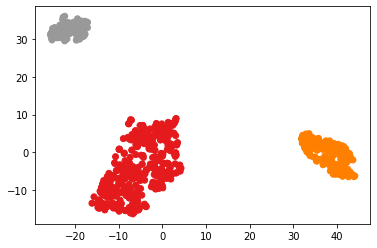

In [18]:
tsne = TSNE(n_components=2, perplexity=50)
elements_tsne = tsne.fit_transform(matrices_for_embedding)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners, cmap='Set1')

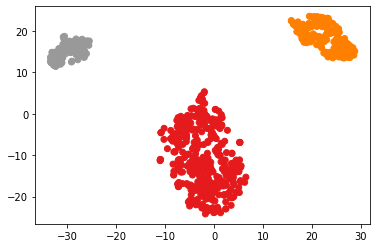

In [24]:
transformer = SparseRandomProjection(random_state=156165, n_components=30)
transformer.fit(base_matrices)

emb_trans = transformer.transform(matrices_for_embedding)
elements_tsne = tsne.fit_transform(emb_trans)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners, cmap='Set1')

In [40]:
trans_initelements = transformer.transform(base_matrices[:64])
clf = IsolationForest(n_estimators=10, random_state=156165).fit(trans_initelements)

In [41]:
c = [clf.decision_function(emb_trans)>0]

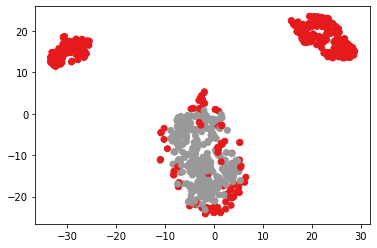

In [42]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=c, cmap='Set1')

In [3]:
device = torch.device('cuda')
#stylemodel = tvmodels.resnet50(pretrained=True) #maybe different model?

stylemodel = EncoderModelGenesis()

#Load pretrained model genesis
weight_dir = 'models/Genesis_Chest_CT.pt'
checkpoint = torch.load(weight_dir)
state_dict = checkpoint['state_dict']
unParalled_state_dict = {}
for key in state_dict.keys():
    if key.startswith('module.down_'):
        unParalled_state_dict[key.replace("module.", "")] = state_dict[key]
stylemodel.load_state_dict(unParalled_state_dict)


stylemodel = stylemodel.to(device)
stylemodel.eval()

grammatrices = []
gramlayers = [stylemodel.down_tr64.ops[1].conv1]
               #model.layer2[-1].conv1,
               #model.layer3[-1].conv1]
               #model.layer4[-1].conv1]
register_hooks()
collected_matrices = {}

In [4]:
ds = BrainAgeContinuous('/project/catinous/brainds_split.csv')
ds_base = BrainAgeDataset('/project/catinous/brainds_split.csv', split=['base_train'])
dl_base = torch.utils.data.DataLoader(ds_base, num_workers=2, batch_size=2)
dl = torch.utils.data.DataLoader(ds, num_workers=2, batch_size=2)

41
117


In [5]:
matrices_for_embedding = []
scanner = []
base_matrices = []


for batch in dl_base:
    x, y, _, labels = batch
    x = x.to(device)
    out = stylemodel(x)
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        base_matrices.append(gm.detach().cpu().numpy().flatten())
        scanner.append(0)
    grammatrices = []
    
for batch in dl:
    x, y, _, labels = batch
    x = x.to(device)
    out = stylemodel(x)
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
    grammatrices = []
    for l in labels:
        if l=='1.5T Philips':
            scanner.append(0)
        elif l=='3.0T Philips':
            scanner.append(1)
        else:
            scanner.append(2)

In [456]:
base_arr = np.array(base_matrices)
mu = base_arr[:50].mean(axis=0)
std= base_arr[:50].std(axis=0)
mu_3std = mu-(3.0*std)
mu_plus3std = mu+(3.0*std)

(200, 1024)

In [549]:
domain_mus = [mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []

elements = []
pseudodomains = []



for i, m in enumerate(matrices_for_embedding[200:]):
    domain = np.array([euclidean(m, dm) for dm in domain_mus]).argmin()

    mu_3std = domain_mus[domain]-(4.0*domain_stds[domain])
    mu_plus3std = domain_mus[domain]+(4.0*domain_stds[domain])
    
    outlier = False
    for j, b in enumerate(m):
        if b<mu_3std[j] or b>mu_plus3std[j]:
            outlier = True
            
    if outlier:
        new_count[scanner[200+i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[200+i])
        
        if len(outlier_cache)==10:
            new_domain_label = len(domain_mus)
            distances = squareform(pdist(outlier_cache))
            idx = np.array([np.array(sorted(d)[:6]).sum() for d in distances]).argmin()
            indeces = np.argsort(distances[idx])[:5]
            compact_cache = np.array([outlier_cache[i] for i in indeces])
            for c in compact_cache:
                elements.append(c)
                pseudodomains.append(new_domain_label)
            domain_mus.append(compact_cache.mean(axis=0))
            domain_stds.append(compact_cache.std(axis=0))
            
            outlier_cache = [] #not the best thing to do
        
    else:
        elements.append(m)
        pseudodomains.append(domain)
np.unique(pseudodomains, return_counts=True)

In [550]:
np.unique(pseudodomains, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112]),
 array([126,   7,   9,   5,   5,   5,   5,   5,   5,   7,   7,   5, 149,
          8,  13,   5,   9,   6,   6,  10,   8,   9,   5,   5,   9,   6,
         10,   5,   9,  50,  51,   7,   9,  10,  15,   6,   7,   7,   6,
         13,   6,  12,   5,   5,   7,   7,   8,  21,   6,   5,   5,   6,
          5,   7,   5,   8,  12,   6,   5,   6,   5,   8,   5,   5,  

In [568]:
domain_mus = [mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []

elements = []
pseudodomains = []
scanners_elements = []

clf = IsolationForest(n_estimators=10, random_state=323459145).fit(base_arr[:50])
isoforests = [clf]

for i, m in enumerate(matrices_for_embedding[200:]):
    outlier = True
    for j, clf in enumerate(isoforests):
        if outlier:
            if clf.predict(m.reshape(1, -1))!=-1: #TODO: this takes the first pseudo label, but it might be that another psuedo label is better!!
                    pseudodomains.append(j)
                    outlier=False
                    elements.append(m)
                    #scanners_elements.append(scanner[200+i])
    if outlier:
        new_count[scanner[200+i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[200+i])
        
        if len(outlier_cache)==10:
            new_domain_label = len(isoforests)
            #distances = squareform(pdist(outlier_cache))
            #idx = np.array([np.array(sorted(d)[:6]).sum() for d in distances]).argmin()
            #indeces = np.argsort(distances[idx])[:5]
            #compact_cache = np.array([outlier_cache[i] for i in indeces])
            #for c in compact_cache:
            #    elements.append(c)
            #    pseudodomains.append(new_domain_label)
            clf = IsolationForest(n_estimators=10, random_state=2491308414, contamination=0.5).fit(outlier_cache)
            
            #print(clf.predict(outlier_cache))
            
            for k, p in enumerate(clf.predict(outlier_cache)):
                if p==1:
                    elements.append(outlier_cache[k])
                    pseudodomains.append(new_domain_label)
            
            isoforests.append(clf)
            
            outlier_cache = [] #not the best thing to do

In [569]:
np.unique(pseudodomains, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 95, 414, 235, 149, 139,   6, 170, 180,  81, 144,  20,  11]))

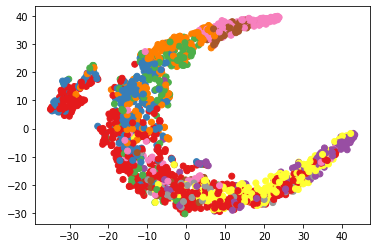

In [570]:
tsne = TSNE(n_components=2, perplexity=50)
elements_tsne = tsne.fit_transform(elements)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=pseudodomains, cmap='Set1')

In [ ]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=pseudodomains, cmap='Set1')

In [500]:
domain_mus = [mu,cache_mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []
outliers = []

for i, m in enumerate(matrices_for_embedding):
        
    outlier = False
    for j, b in enumerate(m):
        if b<mu_3std[j] or b>mu_plus3std[j]:
            outlier = True
    if outlier:
        new_count[scanner[i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[i])
    outliers.append(outlier)

In [476]:
test_cache = outlier_cache[:10]
distances = squareform(pdist(test_cache))
np.array([np.array(sorted(d)[1:6]).sum() for d in distances])

array([0.12071742, 0.16377655, 0.33526106, 0.12872205, 0.11783462,
       0.14420113, 0.13582333, 0.18172506, 0.11885718, 0.13722116])

In [478]:
pdist(test_cache).shape

(45,)

In [470]:
test_cache = outlier_cache[10:25]
distances = squareform(pdist(test_cache))
np.array([np.array(sorted(d)[1:6]).sum() for d in distances])

array([0.1976914 , 0.15858781, 0.50638191, 0.36322299, 0.14972052,
       0.16474966, 0.12019986, 0.13214153, 0.29908643, 0.19506673,
       0.1715666 , 0.23233148, 0.11623907, 0.12802128, 0.19285182])

In [471]:
test_cache = outlier_cache[10:25]
distances = squareform(pdist(test_cache))
idx = np.array([np.array(sorted(d)[1:6]).sum() for d in distances]).argmin()
compact_cache = np.array([test_cache[i] for i in np.argsort(distances[idx])[:5]])

In [455]:
cache_mu = compact_cache.mean(axis=0)
cache_std = compact_cache.std(axis=0)

In [472]:
idx

12

In [514]:
tsne = TSNE(n_components=2, perplexity=30)
emb_matrices = np.vstack((matrices_for_embedding, mu, mu_3std, mu_plus3std))
mat_trans = tsne.fit_transform(emb_matrices)

In [507]:
len(outliers)

1900

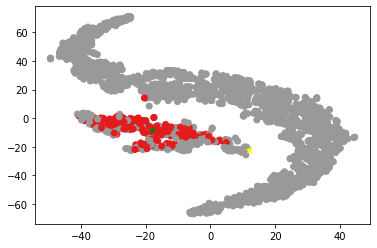

In [517]:
plt.scatter(mat_trans[:1900, 0], mat_trans[:1900, 1], c=outliers, cmap='Set1')
plt.scatter(mat_trans[1901, 0], mat_trans[1901, 1], c='green', marker='*')
plt.scatter(mat_trans[1903, 0], mat_trans[1903, 1], c='yellow', marker='*')

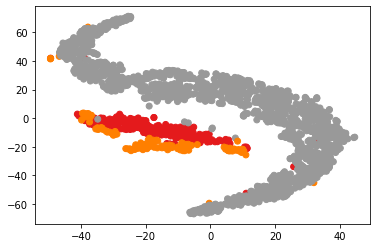

In [519]:
plt.scatter(mat_trans[:1900, 0], mat_trans[:1900, 1], c=scanner, cmap='Set1')

In [369]:
outlier_cache = []
outlier_scanners = []
for i, m in enumerate(matrices_for_embedding[200:]):
    distance = euclidean(m, mu)
    if clf.predict(m.reshape(1, -1))==-1:
        new_count[scanner[200+i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[200+i])
           
print(new_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [367]:
clf = IsolationForest(n_estimators=10, random_state=323459145).fit(base_arr[:50])

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []
for i, m in enumerate(matrices_for_embedding[200:]):
    distance = euclidean(m, mu)
    if clf.predict(m.reshape(1, -1))==-1:
        new_count[scanner[200+i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[200+i])
           
print(new_count)

{0: 18, 1: 102, 2: 1486}


In [392]:
test_cache = outlier_cache[15:25]
outlier_scanners[15:25]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1]

In [406]:
distances = squareform(pdist(test_cache))
idx = np.array([np.array(sorted(d)[1:6]).sum() for d in distances]).argmin()
np.argsort(distances[3])[:5]

array([3, 0, 5, 9, 8])

In [409]:
distances[idx]

array([0.02501244, 0.18742735, 0.09520343, 0.        , 0.0734624 ,
       0.03038382, 0.05132294, 0.13353274, 0.04821279, 0.03126397])

In [414]:

np.array([euclidean(mu, c) for c in base_arr]).mean()

0.026951520300935953

In [383]:
sorted(squareform(pdist(test_cache))[0])[1:6]

[0.013381840503395965,
 0.026028991915844284,
 0.02885142135551405,
 0.03235257618939177,
 0.04119066872881931]

In [386]:
sorted(squareform(pdist(test_cache))[1])[1:6]

[0.015269152335095484,
 0.018292599627166763,
 0.028104527749477106,
 0.02931569111262546,
 0.029754348443798314]

In [14]:
new_count = {0:0, 1:0, 2:0}
outlier_cache = []
for i, m in enumerate(matrices_for_embedding):
    distance = euclidean(m, mu)
    if distance>max_dev:
        new_count[scanner[i]] += 1
        outlier_cache.append(m)
        if len(outlier_cache)>5:
            mu_out = np.array(outlier_cache).mean(axis=0)
            std_out = np.array(outlier_cache).std(axis=0)
            distances_out = np.array([euclidean(m, mu_out) for m in outlier_cache])
            if distances_out.max()<distances_base.max():
                print(distances_out, new_count)
                break
print(new_count)

[0.06792373 0.01821236 0.0817325  0.02493632 0.02233484 0.08826841] {0: 6, 1: 0, 2: 0}
{0: 6, 1: 0, 2: 0}


In [577]:
ocs = OneClassSVM(gamma='auto').fit(base_arr[:20])
ocs.predict(base_arr)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1])

In [579]:
np.unique(ocs.predict(base_arr), return_counts=True), np.unique(ocs.predict(matrices_for_embedding), return_counts=True)

((array([-1,  1]), array([ 21, 179])), (array([-1,  1]), array([1038,  863])))

In [7]:
tsne = TSNE(n_components=2, perplexity=30)
mat_trans = tsne.fit_transform(matrices_for_embedding)

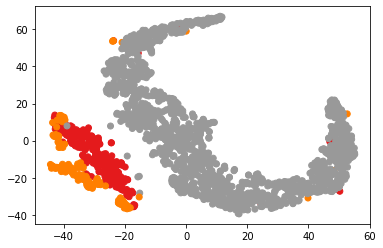

In [8]:
plt.scatter(mat_trans[:, 0], mat_trans[:, 1], c=scanner, cmap='Set1')

In [6]:
transform = SparseRandomProjection(random_state=3243255, n_components=30)
base_trans = transform.fit_transform(base_matrices)
matrices_trans = transform.transform(matrices_for_embedding)

In [13]:
tsne = TSNE(n_components=2, random_state=214135)
mat_trans_trans = tsne.fit_transform(matrices_trans)

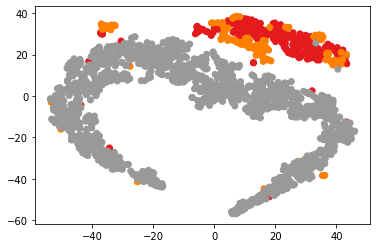

In [14]:
plt.scatter(mat_trans_trans[:, 0], mat_trans_trans[:, 1], c=scanner, cmap='Set1')

In [102]:
x = base_pca[20]
mu = base_pca.mean(axis=0)
sigma = np.cov(base_pca.T)
m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
m_dist_x = np.dot(m_dist_x, (x-mu))
(1-stats.chi2.cdf(m_dist_x, 3), m_dist_x)

(0.0016207336100175773, 15.24247687447837)

In [103]:


x = matrices_pca[700]

m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
m_dist_x = np.dot(m_dist_x, (x-mu))
1-stats.chi2.cdf(m_dist_x, 3), m_dist_x

(0.0, 151.7242184096083)

In [100]:
from  scipy.spatial.distance import mahalanobis, euclidean

In [104]:
distances = np.array([mahalanobis(m, mu, np.linalg.inv(sigma)) for m in matrices_pca])

In [105]:
distances[np.array(scanner)==0].mean(), distances[np.array(scanner)==1].mean(), distances[np.array(scanner)==2].mean(), 

(4.3875360208308605, 8.660386539932517, 12.030473743684684)

In [95]:
len(x)

200

In [109]:
distances_eu[np.array(scanner)==0].mean(), distances_eu[np.array(scanner)==1].mean(), distances_eu[np.array(scanner)==2].mean(), 

(0.02751501090824604, 0.03858610857019408, 0.07635739635232777)

In [111]:
distances_eu[np.array(scanner)==0].max(), distances_eu[np.array(scanner)==1].max(), distances_eu[np.array(scanner)==2].max()

(0.1571204662322998, 0.2104555368423462, 0.3073861598968506)

0.08882248326799902

In [155]:
base_arr[0].shape

(1024,)

In [79]:
device = torch.device('cuda')
stylemodel = tvmodels.resnet50(pretrained=True) #maybe different model?
stylemodel_cut = nn.Sequential(*list(stylemodel.children())[:5])

stylemodel_cut = stylemodel_cut.to(device)
stylemodel_cut.eval()

grammatrices = []
gramlayers = [stylemodel_cut[4][1].conv2]
               #model.layer2[-1].conv1,
               #model.layer3[-1].conv1]
               #model.layer4[-1].conv1]
register_hooks_2d(gramlayers)
collected_matrices = {}

In [80]:
ds = BrainAgeContinuous('/project/catinous/brainds_split.csv')
ds_base = BrainAgeDataset('/project/catinous/brainds_split.csv', split=['base_train'])
dl_base = torch.utils.data.DataLoader(ds_base, num_workers=2, batch_size=1)
dl = torch.utils.data.DataLoader(ds, num_workers=2, batch_size=1)

41
117


In [81]:
matrices_for_embedding = []
scanner = []
base_matrices = []


for batch in dl_base:
    x, y, _, labels = batch
    img_sample = x[:, :, 2*int(img.shape[2]/3), :, :]
    img_sample = np.tile(img_sample, [1, 3, 1, 1])

    img_sample = torch.tensor(img_sample).to(device)
    out = stylemodel_cut(img_sample)
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        base_matrices.append(gm.detach().cpu().numpy().flatten())
        scanner.append(0)
    grammatrices = []
    
for batch in dl:
    x, y, _, labels = batch
    img_sample = x[:, :, 2*int(img.shape[2]/3), :, :]
    img_sample = np.tile(img_sample, [1, 3, 1, 1])

    img_sample = torch.tensor(img_sample).to(device)
    out = stylemodel_cut(img_sample)
    
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
    grammatrices = []
    for l in labels:
        if l=='1.5T Philips':
            scanner.append(0)
        elif l=='3.0T Philips':
            scanner.append(1)
        else:
            scanner.append(2)

In [82]:
base_matrices[0].shape

(4096,)

In [83]:
base_arr = np.array(base_matrices)

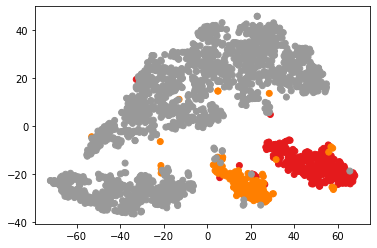

In [150]:
tsne = TSNE(n_components=2, perplexity=30, random_state=234234)
mat_trans = tsne.fit_transform(matrices_for_embedding)
plt.scatter(mat_trans[:, 0], mat_trans[:, 1], c=scanner, cmap='Set1')

In [24]:
transform = SparseRandomProjection(random_state=3243255, n_components=30)
base_trans = transform.fit_transform(base_arr)
matrices_trans = transform.transform(matrices_for_embedding)

torch.Size([1, 1, 128, 128])

In [15]:
mu = base_trans.mean(axis=0)
std= base_trans.std(axis=0)
mu_3std = mu-(3.0*std)
mu_plus3std = mu+(3.0*std)

In [32]:
domain_mus = [mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []

elements = []
pseudodomains = []
elements_scanner = []

outlier_cnt_exp = []

for i, m in enumerate(matrices_trans):
    domain = np.array([euclidean(m, dm) for dm in domain_mus]).argmin()

    mu_3std = domain_mus[domain]-(3.0*domain_stds[domain])
    mu_plus3std = domain_mus[domain]+(3.0*domain_stds[domain])
    
    outlier = False
    outlier_cnt = 0

    for j, b in enumerate(m):
        if b<mu_3std[j] or b>mu_plus3std[j]:
            outlier_cnt += 1
    if outlier_cnt>2:
        outlier = True
            
    if outlier:
        new_count[scanner[i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[i])
        
        if len(outlier_cache)==10:
            new_domain_label = len(domain_mus)
            distances = squareform(pdist(outlier_cache))
            idx = np.array([np.array(sorted(d)[:6]).sum() for d in distances]).argmin()
            indeces = np.argsort(distances[idx])[:5]
            compact_cache = np.array([outlier_cache[k] for k in indeces])
            elements_scanner.extend(np.array([outlier_scanners[k] for k in indeces]))
            for c in compact_cache:
                elements.append(c)
                pseudodomains.append(new_domain_label)
            domain_mus.append(compact_cache.mean(axis=0))
            domain_stds.append(compact_cache.std(axis=0))
            
            outlier_cache = [] #not the best thing to do
        
    else:    
        elements.append(m)
        pseudodomains.append(domain)
        elements_scanner.append(scanner[i])
        pseudo_elements = np.array(elements)[np.array(pseudodomains)==domain]
        if len(pseudo_elements)<32:
            domain_mus[domain] = pseudo_elements.mean(axis=0)
            domain_stds[domain] = pseudo_elements.std(axis=0)
np.unique(pseudodomains, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([  1, 139, 197,  13, 109,  88,  75,   7, 173, 160, 265, 221,  44,
         74,  35, 101,  69,  27,   5]))

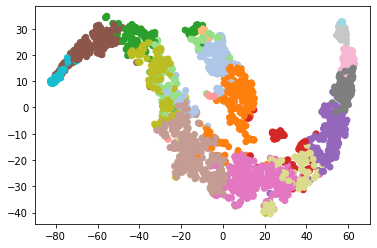

In [33]:
tsne = TSNE(n_components=2, random_state=2335355)
elements_tsne = tsne.fit_transform(elements)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=pseudodomains, cmap='tab20')

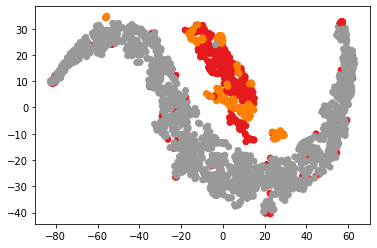

In [34]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=elements_scanner, cmap='Set1')

In [146]:
domain_mus = [mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []

elements = []
pseudodomains = []
scanners_elements = []

clf = IsolationForest(n_estimators=10, random_state=323459145).fit(base_arr)
isoforests = [clf]

for i, m in enumerate(matrices_for_embedding[200:]):
    outlier = True
    for j, clf in enumerate(isoforests):
        if outlier:
            if clf.predict(m.reshape(1, -1))!=-1: #TODO: this takes the first pseudo label, but it might be that another psuedo label is better!!
                    pseudodomains.append(j)
                    outlier=False
                    elements.append(m)
                    scanners_elements.append(scanner[200+i])
                    if j!=0:
                        pseudo_elements = np.array(elements)[np.array(pseudodomains)==j]
                        if len(pseudo_elements)<32:
                            clf = isoforests[j]
                            clf.set_params(n_estimators=len(clf.estimators_)+3)
                            isoforests[j] = clf.fit(pseudo_elements)
    if outlier:
        new_count[scanner[200+i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[200+i])
        
        if len(outlier_cache)==10:
            new_domain_label = len(isoforests)
            clf = IsolationForest(n_estimators=5, random_state=2491308414, warm_start=True, contamination=0.10).fit(outlier_cache) 
            #have to do a pre selection of cache elements here based on 
            
            #print(clf.predict(outlier_cache))
            
            for k, p in enumerate(clf.predict(outlier_cache)):
                if p==1:
                    elements.append(outlier_cache[k])
                    pseudodomains.append(new_domain_label)
                    scanners_elements.append(outlier_scanners[k])
            
            isoforests.append(clf)
            
            outlier_cache = [] #not the best thing to do
            outlier_scanner = []

In [148]:
np.unique(pseudodomains, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([234, 935, 348, 131,  38,  10]))

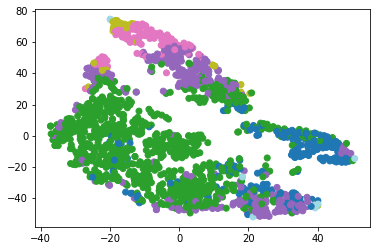

In [147]:
tsne = TSNE(n_components=2)
elements_tsne = tsne.fit_transform(elements)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=pseudodomains, cmap='tab20')

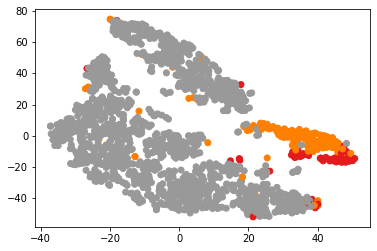

In [149]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners_elements, cmap='Set1')

In [137]:
clf = isoforests[0]

In [145]:
np.unique(clf.predict(np.array(matrices_for_embedding)[np.array(scanner)==1]), return_counts=True)

(array([-1,  1]), array([61, 83]))

In [19]:
domain_mus = [mu]
domain_stds = [std]

new_count = {0:0, 1:0, 2:0}
outlier_cache = []
outlier_scanners = []

elements = []
pseudodomains = []
scanners_elements = []

clf = IsolationForest(n_estimators=10, random_state=323459145, n_jobs=-1).fit(base_trans)
isoforests = [clf]

for i, m in enumerate(matrices_trans):
    outlier = True
    
    current_max = 0.0
    current_j = -1
    for j, clf in enumerate(isoforests):
        pred = clf.decision_function(m.reshape(1, -1))
        if pred>current_max:
            current_max = pred
            current_j = j
            
    if current_j!=-1:
        pseudodomains.append(current_j)
        outlier=False
        elements.append(m)
        scanners_elements.append(scanner[i])
        if current_j!=0:
            pseudo_elements = np.array(elements)[np.array(pseudodomains)==current_j]
            if len(pseudo_elements)<32:
                clf = isoforests[current_j]
                clf.set_params(n_estimators=len(clf.estimators_)+3)
                isoforests[current_j] = clf.fit(pseudo_elements)
      
    if outlier:
        new_count[scanner[i]] += 1
        outlier_cache.append(m)
        outlier_scanners.append(scanner[i])
        
        if len(outlier_cache)==10:
            new_domain_label = len(isoforests)
            distances = squareform(pdist(outlier_cache))
            idx = np.array([np.array(sorted(d)[:6]).sum() for d in distances]).argmin()
            indeces = np.argsort(distances[idx])[:5]
            compact_cache = np.array([outlier_cache[i] for i in indeces])
            #for c in compact_cache:
            #    elements.append(c)
            #    pseudodomains.append(new_domain_label)
            clf = IsolationForest(n_estimators=5, random_state=2491308414, warm_start=True, contamination=0.10, n_jobs=-1).fit(outlier_cache) #have to do a pre selection of cache elements here based on 
            
            #print(clf.predict(outlier_cache))
            
            for k, p in enumerate(clf.predict(outlier_cache)):
                if p==1:
                    elements.append(outlier_cache[k])
                    pseudodomains.append(new_domain_label)
                    scanners_elements.append(outlier_scanners[k])
            
            isoforests.append(clf)
            
            outlier_cache = [] #not the best thing to do
            outlier_scanner = []

In [23]:
np.unique(pseudodomains, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([282,  49, 123,  50, 336, 766, 132, 130,  25]))

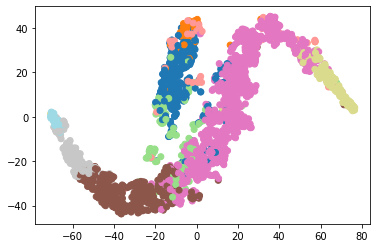

In [24]:
tsne = TSNE(n_components=2, random_state=2352235)
elements_tsne = tsne.fit_transform(elements)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=pseudodomains, cmap='tab20')

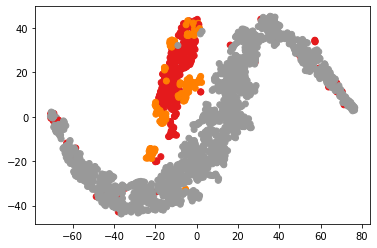

In [25]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=scanners_elements, cmap='Set1')

In [36]:
domaincounter = {0: 23, 1:0}

In [38]:
for k, v in domaincounter.items():
    print(k, v)

0 23
1 0


In [64]:
domain_complete = {0: True, 3: True, 2:False}

In [62]:
np.all(list(domain_complete.values()))

True

In [63]:
for d in domain_complete:
    print(d)

0
3


In [65]:
domain_items = [d if d else None for d in domain_complete]

In [5]:
device = torch.device('cuda')
stylemodel = tvmodels.resnet50(pretrained=True)

stylemodel = stylemodel.to(device)
stylemodel.eval()

grammatrices = []
gramlayers = [stylemodel.layer2[-1].conv1]
               #model.layer3[-1].conv1]
               #model.layer4[-1].conv1]
register_hooks_2d(gramlayers)
collected_matrices = {}

In [6]:
dl = torch.utils.data.DataLoader(CatsinomDataset('/project/catinous/cat_data/',
                                'catsinom_combined_dsts3_dataset.csv',
                               iterations=None,
                               batch_size=4,
                               split=['base_train'],
                              res='lr'),
                   batch_size=4, num_workers=4, pin_memory=True, shuffle=True)

In [17]:
gms = []
res = []

for batch in dl:
    torch.cuda.empty_cache()


    x, y, filepath, scanner = batch
    x = x.to(device)
    y_style = stylemodel(x.float())

    for i, f in enumerate(filepath):
        gms.append(grammatrices[0][i].detach().cpu().numpy().flatten())
        res.append(scanner[i])

    grammatrices = []

In [16]:
dl = torch.utils.data.DataLoader(CatsinomDataset('/project/catinous/cat_data/',
                                'catsinom_combined_dsts3_dataset.csv',
                               iterations=None,
                               batch_size=4,
                               split=['val'],
                              res='lr'),
                   batch_size=4, num_workers=4, pin_memory=True, shuffle=True)

In [9]:
spr = SparseRandomProjection(random_state=31515, n_components=30)
spr_trans = spr.fit_transform(gms[:64])

In [10]:
clf = IsolationForest(n_estimators=10, random_state=31515).fit(spr_trans)

In [18]:
spr_trans_out = spr.transform(gms[-64:])

In [20]:
clf.predict(spr_trans_out)

array([ 1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

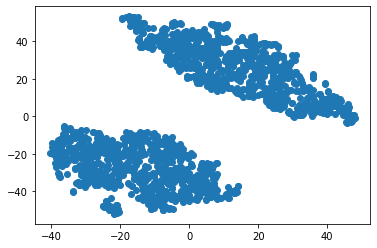

In [19]:
tsne = TSNE(n_components=2, random_state=2352235)
elements_tsne = tsne.fit_transform(spr_trans)
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], cmap='tab20')

In [22]:
r_c = []
for r in res:
    if r=='lr':
        r_c.append(0)
    elif r=='hr':
        r_c.append(1)
    else:
        r_c.append(2)


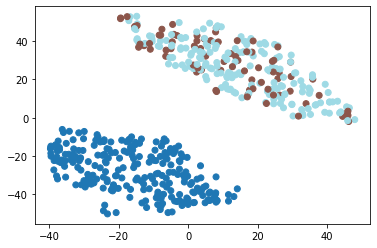

In [35]:
plt.scatter(elements_tsne[:500, 0], elements_tsne[:500, 1], cmap='tab20', c=r_c[:500])

In [31]:
r = list(r_c[:500])